# Time-series prediction with Keras `SimpleRNN` class
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---
### What is this Notebook about?
In this notebook, we show a building simple recurrent neural network (RNN) using Keras.

We will generate some synthetic time-series data by multiplying two periodic/ sinusoidal signals and adding some stochasticity (Gaussian noise). Then, we will take a small fraction of the data and train a simple RNN model with it and try to predict the rest of the data and see how the predictions match up with the ground truth.

In [156]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input
from keras.optimizers import RMSprop
from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler

In [157]:
file = pd.read_csv("AMAZON.csv", sep=';')
file=file.loc[::-1].reset_index(drop=True)
file

,Date,open,high,low,close,volume
0,1/2/2024 4:00,152.45,152.86,152.12,152.500,2047
1,1/2/2024 4:01,152.65,152.68,152.44,152.600,203
2,1/2/2024 4:02,152.65,152.66,152.64,152.650,1187
3,1/2/2024 4:03,152.52,152.52,152.50,152.500,100
4,1/2/2024 4:04,152.52,152.52,152.36,152.360,1740
...,...,...,...,...,...,...
116810,6/28/2024 19:55,193.33,193.35,193.25,193.270,895
116811,6/28/2024 19:56,193.30,193.34,193.25,193.315,217
116812,6/28/2024 19:57,193.32,193.35,193.24,193.350,429
116813,6/28/2024 19:58,193.32,193.35,193.28,193.300,765


In [158]:
N=60     #Minutos agrupados
DateFilter='' #Filtro de fecha

df = file[file['Date'].str.startswith(DateFilter)]
df=pd.DataFrame(df)
df=df.drop(columns=["Date"])
dfgroup=pd.DataFrame(df['open'].groupby(df.index//N).first())
dfgroup=dfgroup.join(pd.DataFrame(df['close'].groupby(df.index//N).last()))
dfgroup=dfgroup.join(pd.DataFrame(df['low'].groupby(df.index//N).min()))
dfgroup=dfgroup.join(pd.DataFrame(df['high'].groupby(df.index//N).max()))
dfgroup=dfgroup.join(pd.DataFrame(df['volume'].groupby(df.index//N).sum()))
dfgroup = dfgroup.reset_index(drop=True)
dfgroup

,open,close,low,high,volume
0,152.4500,152.140,151.9700,152.860,23899
1,152.1400,151.910,151.8200,152.140,21762
2,151.8800,150.920,150.7600,151.880,46962
3,150.9000,150.350,150.1000,153.000,151845
4,150.3000,150.570,150.1000,152.935,233050
...,...,...,...,...,...
1942,194.5900,193.210,192.5000,194.675,44264009
1943,193.2001,193.230,184.8245,193.860,10876365
1944,193.2200,193.250,193.1000,193.320,46348
1945,193.2500,193.245,193.1100,193.280,16889


In [159]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

dfgroup['EMA7']= dfgroup['close'].ewm(span=7, adjust=False).mean()
dfgroup['MACD']= dfgroup['close'].ewm(span=12, adjust=False).mean()- dfgroup['close'].ewm(span=26, adjust=False).mean()
dfgroup['SignalMACD'] = dfgroup['MACD'].ewm(span=9, adjust=False).mean()
dfgroup['RSI'] = get_rsi(dfgroup['close'], 14)
dfgroup = dfgroup.dropna()
dfgroup = dfgroup.reset_index(drop=True)
dfgroup


,open,close,low,high,volume,EMA7,MACD,SignalMACD,RSI
0,150.3000,150.5700,150.1000,152.935,233050,151.216055,-0.300307,-0.112796,12.310729
1,150.5700,149.6900,148.8600,152.380,9796372,150.834541,-0.423217,-0.174880,8.044607
2,149.6900,149.0400,148.3900,149.819,5621409,150.385906,-0.566543,-0.253213,6.306259
3,149.0400,150.8321,148.9800,150.930,5470169,150.497454,-0.529419,-0.308454,42.925408
4,150.8321,149.5900,149.5900,150.950,3158193,150.270591,-0.593386,-0.365441,33.231021
...,...,...,...,...,...,...,...,...,...
1938,194.5900,193.2100,192.5000,194.675,44264009,195.243164,0.149751,0.964879,35.907277
1939,193.2001,193.2300,184.8245,193.860,10876365,194.739873,-0.077894,0.756324,36.050123
1940,193.2200,193.2500,193.1000,193.320,46348,194.367405,-0.253765,0.554306,36.203246
1941,193.2500,193.2450,193.1100,193.280,16889,194.086804,-0.389063,0.365633,36.179922


In [160]:
PROFIT=1

decision=dfgroup['close'].iloc[:]
decision = decision.iloc[1:].reset_index(drop=True) - decision
decision = decision.dropna().reset_index(drop=True)
decision = np.where(abs(decision)<PROFIT,0,np.sign(decision).astype('int'))
decision = pd.DataFrame(data={'buysell':decision})#.drop(0).reset_index(drop=True)
normData = dfgroup.join(decision)
normData = normData.iloc[:-2,:]
normData

,open,close,low,high,volume,EMA7,MACD,SignalMACD,RSI,buysell
0,150.3000,150.5700,150.1000,152.935,233050,151.216055,-0.300307,-0.112796,12.310729,0.0
1,150.5700,149.6900,148.8600,152.380,9796372,150.834541,-0.423217,-0.174880,8.044607,0.0
2,149.6900,149.0400,148.3900,149.819,5621409,150.385906,-0.566543,-0.253213,6.306259,1.0
3,149.0400,150.8321,148.9800,150.930,5470169,150.497454,-0.529419,-0.308454,42.925408,-1.0
4,150.8321,149.5900,149.5900,150.950,3158193,150.270591,-0.593386,-0.365441,33.231021,0.0
...,...,...,...,...,...,...,...,...,...,...
1936,194.7700,195.4600,194.5900,195.460,3795837,196.361180,0.662913,1.350784,46.450178,0.0
1937,195.4500,194.6000,194.5800,195.560,3802362,195.920885,0.440167,1.168661,41.955304,-1.0
1938,194.5900,193.2100,192.5000,194.675,44264009,195.243164,0.149751,0.964879,35.907277,0.0
1939,193.2001,193.2300,184.8245,193.860,10876365,194.739873,-0.077894,0.756324,36.050123,0.0


In [161]:
print('Buy and Sell points: ', np.count_nonzero(normData['buysell']))

Buy and Sell points:  227


In [162]:
#Normalise data into (0,1) range
scaler = MinMaxScaler(feature_range=(0, 1))
#normData[['open']] = scaler.fit_transform(normData[['open']])
normData[['open','close','low','high','volume','EMA7','MACD','SignalMACD','RSI']] = scaler.fit_transform(normData[['open','close','low','high','volume','EMA7','MACD','SignalMACD','RSI']])
normData

,open,close,low,high,volume,EMA7,MACD,SignalMACD,RSI,buysell
0,0.116052,0.120933,0.490600,0.103362,0.004429,0.125855,0.284342,0.308448,0.074238,0.0
1,0.120933,0.105025,0.477503,0.096757,0.190133,0.118803,0.261885,0.295699,0.021493,0.0
2,0.105025,0.093275,0.472539,0.066278,0.109062,0.110509,0.235698,0.279613,0.000000,1.0
3,0.093275,0.125671,0.478771,0.079500,0.106125,0.112571,0.242481,0.268270,0.452751,-1.0
4,0.125671,0.103218,0.485213,0.079738,0.061231,0.108378,0.230794,0.256567,0.332892,0.0
...,...,...,...,...,...,...,...,...,...,...
1936,0.919920,0.932393,0.960499,0.609461,0.073613,0.960378,0.460329,0.608998,0.496330,0.0
1937,0.932213,0.916847,0.960393,0.610652,0.073739,0.952239,0.419632,0.571598,0.440757,-1.0
1938,0.916667,0.891721,0.938424,0.600119,0.859435,0.939711,0.366571,0.529751,0.365980,0.0
1939,0.891542,0.892082,0.857356,0.590420,0.211104,0.930408,0.324978,0.486924,0.367746,0.0


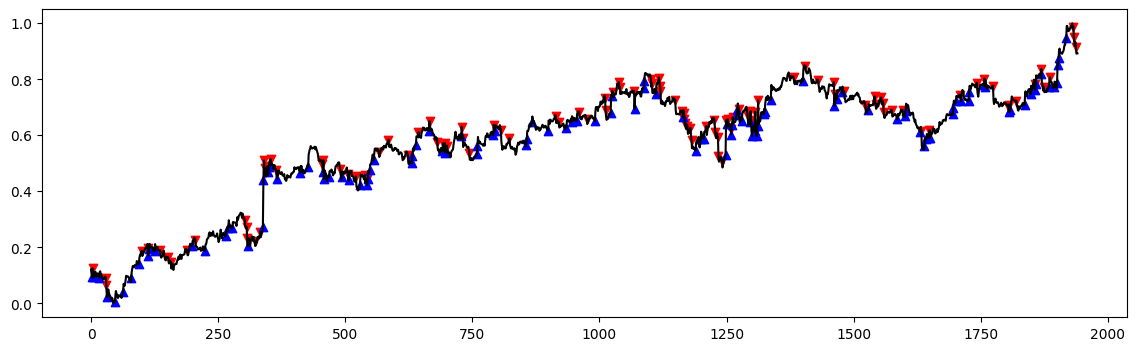

In [163]:
plt.figure(figsize=(14,4))
plt.plot(normData['close'],color='black')
plt.scatter(normData.index, np.where(normData['buysell'] == -1,normData['close'], None), color="red", marker="v")
plt.scatter(normData.index, np.where(normData['buysell'] ==  1,normData['close'], None), color="blue", marker="^")
plt.show()

### Split the values in train and test

So, we took only 25% of the data as training samples and set aside the rest of the data for testing.

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

In [164]:
S=0.7
step = 60

split = int(len(normData) * S)
#values = normData.values
#print(values)
train = normData[:split]#.drop(['buysell'],axis=1)
test = pd.concat([train.tail(step),normData[split:]]).reset_index(drop=True)

print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (1358, 10)
Test data length: (643, 10)


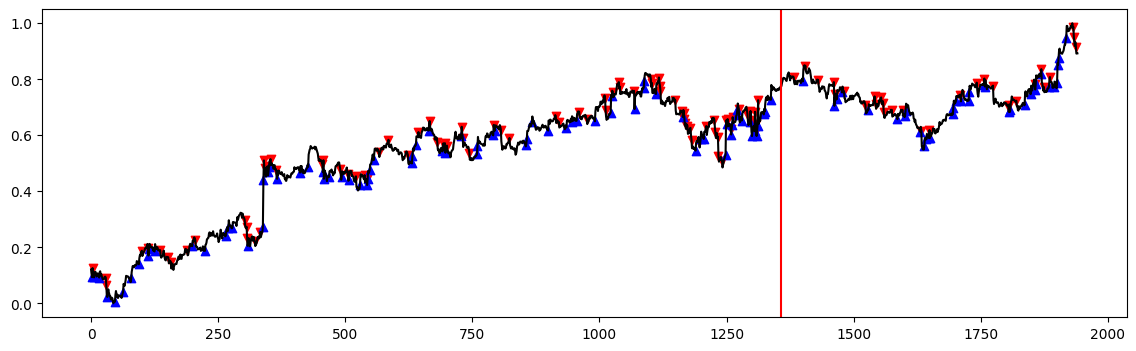

In [165]:


index = normData.index.values

plt.figure(figsize=(14,4))
plt.plot(index,normData['close'],c='black')
#plt.plot(index[split:],test['close'],c='olive',alpha=0.7)
#plt.legend(['Train','Test'])
plt.axvline(normData.index[split], c="r")
plt.scatter(normData.index, np.where(normData['buysell'] == -1,normData['close'], None), color="red",  marker="v")
plt.scatter(normData.index, np.where(normData['buysell'] ==  1,normData['close'], None), color="blue", marker="^")
plt.show()


In [166]:
'''

aux = train.tail(step)
train= pd.concat([train, test.head(step)]).reset_index(drop=True)
test = pd.concat([aux,test]).reset_index(drop=True)
print("Train data length:", train.shape)
print("Test data length:", test.shape)'''

'\n\naux = train.tail(step)\ntrain= pd.concat([train, test.head(step)]).reset_index(drop=True)\ntest = pd.concat([aux,test]).reset_index(drop=True)\nprint("Train data length:", train.shape)\nprint("Test data length:", test.shape)'

### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [167]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        #print(i, d, data[i:d,:-1])
        X.append(data[i:d,:-1])
        Y.append(data[d,-1])
    return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train.to_numpy(),step)
testX,testY =convertToMatrix(test.to_numpy(),step)
#print(trainX)
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)


Training data shape: (1298, 60, 9) ,  (1298,)
Test data shape: (583, 60, 9) ,  (583,)


### Keras model with `SimpleRNN` layer

- 256 neurons in the RNN layer
- 32 denurons in the densely connected layer
- a single neuron for the output layer
- ReLu activation
- learning rate: 0.001

In [168]:
UNITS = 150 #num_units: Number of units of a the simple RNN layer
DENSEUNITS = 32 #Number of neurons in the dense layer followed by the RNN layer
LR = 0.001 #Learning rate (uses RMSprop optimizer)

model = Sequential()
model.add(Input((step, trainX.shape[2])))
model.add(SimpleRNN(units=UNITS, activation="relu",return_sequences=True))
model.add(SimpleRNN(units=UNITS//2, activation="relu",return_sequences=True))
model.add(SimpleRNN(units=UNITS//3, activation="relu"))
model.add(Dense(DENSEUNITS, activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=RMSprop(LR),metrics=['mse'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_19 (SimpleRNN)       │ (None, 60, 150)        │        24,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ (None, 60, 75)         │        16,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_21 (SimpleRNN)       │ (None, 50)             │         6,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,915 (191.07 KB)

 Trainable params: 48,915 (191.07 KB)

 Non-trainable params: 0 (0.00 B)

### Fit the model

In [169]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if ((epoch/10)+1) % 10 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+10))

batch_size=16
num_epochs = 1000

model.fit(trainX,trainY,
          epochs=num_epochs,
          batch_size=batch_size,
          callbacks=[MyCallback()],verbose=0)

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done
Epoch number 600 done
Epoch number 700 done
Epoch number 800 done
Epoch number 900 done
Epoch number 1000 done


### Plot loss

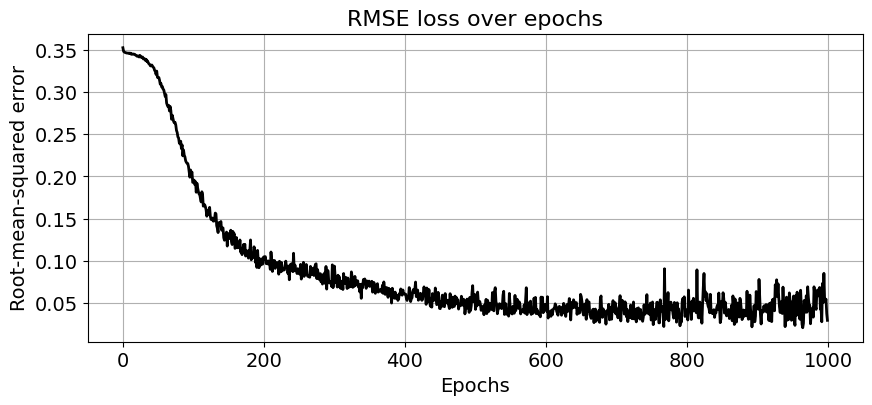

In [170]:
plt.figure(figsize=(10,4))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data.

In [171]:
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)
print(trainPredict.shape)
print(testPredict.shape)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(1298, 1)
(583, 1)


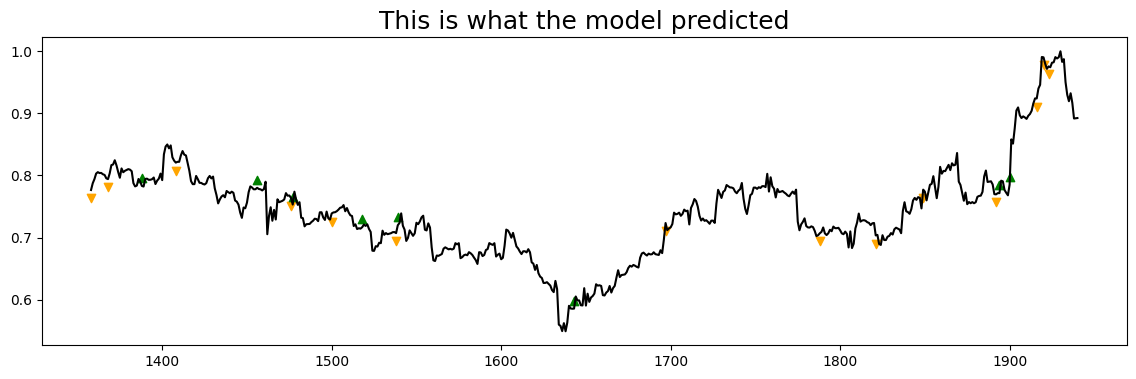

In [172]:
plt.figure(figsize=(14,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(normData['close'].iloc[split:],color='black')
p = np.round(testPredict,0).T[0]
plt.scatter(normData['close'].iloc[split:].index, np.where(p == -1,normData['close'].iloc[split:]-0.013, None), color="orange",  marker="v")
plt.scatter(normData['close'].iloc[split:].index, np.where(p ==  1,normData['close'].iloc[split:]+0.013, None), color="green",   marker="^")

plt.show()

### Comparing it with the ground truth (test set)

(583,) (583,)


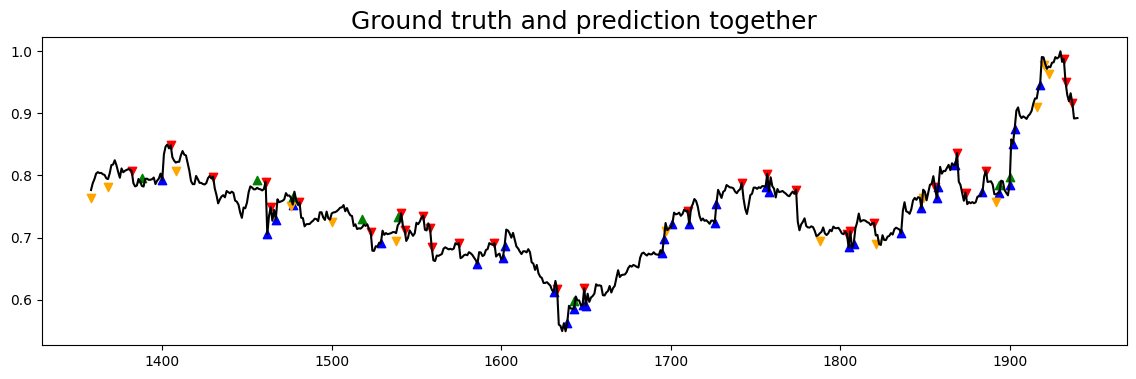

In [173]:
offset=0

index = normData.index.values
plt.figure(figsize=(14,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(normData['close'].iloc[split+offset:],color='black')

print(normData['close'].iloc[split:].index.shape, normData['buysell'].iloc[split:].shape)

plt.scatter(normData['close'].iloc[split+offset:].index, np.where(normData['buysell'].iloc[split+offset:] == -1,normData['close'].iloc[split+offset:], None), color="red",  marker="v")
plt.scatter(normData['close'].iloc[split+offset:].index, np.where(normData['buysell'].iloc[split+offset:] ==  1,normData['close'].iloc[split+offset:], None), color="blue", marker="^")

p = np.round(testPredict[offset:],0).T[0]
plt.scatter(normData['close'].iloc[split+offset:].index, np.where(p == -1,normData['close'].iloc[split+offset:]-0.013, None), color="orange",  marker="v")
plt.scatter(normData['close'].iloc[split+offset:].index, np.where(p ==  1,normData['close'].iloc[split+offset:]+0.013, None), color="green",   marker="^")

plt.show()